In [1]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
# from collections import OrderedDict
%matplotlib inline

import torchvision.transforms as transforms

In [2]:
# 계층적인 폴더 구조를 갖고 있는 데이터셋을 불러올때 사용 : 폴더 이름 = 클래스 명
from torchvision.datasets import ImageFolder

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

In [5]:
# another
dataset = ImageFolder('data/Images')

test_pct = 0.2
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size

train, val, test = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# custom Dataset
class DogData(Dataset) :
    def __init__(self, ds, transform = None) :
        self.ds = ds
        self.transform = transform
    
    def __len__(self) :
        return len(self.ds)
    
    def __getitem__(self, idx) :
        img, label = self.ds[idx]
        if self.transform :
            img = self.transform(img)
            return img, label

        
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225]) 
                                      ])

val_transforms = transforms.Compose([
                                     transforms.Resize(255), 
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
                                     transforms.Resize(255), 
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


train = DogData(train, train_transforms)
val = DogData(val, val_transforms)
test = DogData(test, test_transforms)


num_workers = 4
batch_size = 16

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, 
                                              num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size,
                                             num_workers=num_workers, shuffle=True)

In [6]:

# ResNet18을 위해 최대한 간단히 수정한 BasicBlock 클래스 정의 : 두개의 convolution으로 구성
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        self.shortcut = nn.Sequential() # identity인 경우
        if stride != 1: # stride가 1이 아니라면, Identity mapping(입력값과 출력값이 같음)이 아닌 경우
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=120):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # 64개의 3x3 필터(filter)를 사용
        # 논문과 필터 개수도 동일하게 사용
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(25088, num_classes) #fully connected layer

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1) # stride가 맨처음 convolution 연산에만 2로 적용, 그 이후에 1
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# ResNet18 함수 정의
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [7]:
resnet = ResNet18().to(device)

In [8]:
# test 실행 
a=torch.Tensor(1,3,224,224).to(device)
out = resnet(a)
print(out)

tensor([[ 1.0107e+00, -1.2956e-01, -1.5022e-01, -8.6283e-01, -2.1740e-01,
          5.9322e-01,  3.0726e-01, -2.8572e-01, -6.3624e-05, -2.7621e-02,
          5.3679e-01, -1.2125e-01, -1.1412e+00,  5.8157e-01,  2.9282e-01,
         -3.4895e-02,  2.1470e-01,  3.6355e-01,  3.3334e-01, -5.5904e-01,
         -3.4468e-01,  2.7047e-01,  3.3255e-02,  4.4940e-02,  1.1195e-01,
          2.7890e-01, -7.4188e-02, -5.8290e-01,  1.3141e+00, -2.3595e-01,
         -6.6026e-01,  7.8959e-01, -1.0109e+00,  2.8891e-01,  3.0610e-01,
         -4.6119e-01, -2.4808e-01,  8.0487e-02, -6.0250e-02,  3.6706e-01,
          5.3499e-01, -2.5119e-01,  4.2025e-01, -1.6216e-01,  4.2144e-01,
          1.4326e+00, -3.9242e-01, -2.9798e-01, -2.4065e-01,  3.2243e-02,
         -3.9907e-01,  2.2065e-01, -4.0792e-01,  3.5146e-01, -1.2525e-01,
          2.7907e-01,  9.1486e-02,  2.4694e-01,  1.4650e-01, -4.8784e-01,
          1.3902e+00, -2.2075e-01,  9.7394e-01,  4.9485e-01,  5.8165e-01,
         -4.2763e-02,  4.0674e-01,  8.

In [12]:
# learning rate를 단계적으로 줄여주는 방법
# 150 -> lr/10
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [13]:
from tqdm.auto import tqdm

In [14]:
# loss
criterion = nn.CrossEntropyLoss()
# backpropagation method
learning_rate = 0.01
optimizer = optim.SGD(resnet.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)
# hyper-parameters
num_epochs = 200
num_batches = len(train_loader)

trn_loss_list = []
val_loss_list = []
for epoch in tqdm(range(num_epochs)):
    adjust_learning_rate(optimizer,epoch)
    trn_loss = 0.0
    for i, data in enumerate(train_loader):
        x, label = data
        x = x.to(device)
        label = label.to(device)
        # grad init
        optimizer.zero_grad()
        # forward propagation
        model_output = resnet(x)
        # calculate loss
        loss = criterion(model_output, label)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        # del (memory issue)
        del loss
        del model_output
        
        # 학습과정 출력
        if (i+1) % 100 == 0: # every 100 mini-batches
            with torch.no_grad(): # very very very very important!!!
                val_loss = 0.0
                corr_num = 0
                total_num = 0
                for j, val in enumerate(val_loader):
                    val_x, val_label = val
                    val_x = val_x.to(device)
                    val_label =val_label.to(device)
                    val_output = resnet(val_x)
                    v_loss = criterion(val_output, val_label)
                    val_loss += v_loss
                    
                    model_label = val_output.argmax(dim=1)
                    corr = val_label[val_label == model_label].size(0)
                    corr_num += corr
                    total_num += val_label.size(0)
            
            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | acc: {:.2f}".format(
                epoch+1, num_epochs, i+1, num_batches, trn_loss / 100, val_loss / len(val_loader), (corr_num / total_num) * 100
            ))            
            
            trn_loss_list.append(trn_loss/100)
            val_loss_list.append(val_loss/len(val_loader))
            trn_loss = 0.0

print("training finished!")

# save
PATH = "./resnet18_05.pt"
torch.save(resnet.state_dict(), PATH)

print("model saved!")

epoch: 1/200 | step: 100/927 | trn loss: 7.3571 | val loss: 4.8030 | acc: 1.03
epoch: 1/200 | step: 200/927 | trn loss: 4.7952 | val loss: 4.7904 | acc: 0.79
epoch: 1/200 | step: 300/927 | trn loss: 4.7858 | val loss: 4.7880 | acc: 0.79
epoch: 1/200 | step: 400/927 | trn loss: 4.7829 | val loss: 4.7853 | acc: 0.97
epoch: 1/200 | step: 500/927 | trn loss: 4.7895 | val loss: 4.7836 | acc: 0.91
epoch: 1/200 | step: 600/927 | trn loss: 4.7823 | val loss: 4.7843 | acc: 0.67
epoch: 1/200 | step: 700/927 | trn loss: 4.7800 | val loss: 4.7829 | acc: 0.85
epoch: 1/200 | step: 800/927 | trn loss: 4.7796 | val loss: 4.7746 | acc: 0.91
epoch: 1/200 | step: 900/927 | trn loss: 4.7741 | val loss: 4.7698 | acc: 1.22
epoch: 2/200 | step: 100/927 | trn loss: 4.7604 | val loss: 4.7589 | acc: 1.22
epoch: 2/200 | step: 200/927 | trn loss: 4.7647 | val loss: 4.7459 | acc: 0.97
epoch: 2/200 | step: 300/927 | trn loss: 4.7545 | val loss: 4.7364 | acc: 1.46
epoch: 2/200 | step: 400/927 | trn loss: 4.7448 | va

epoch: 12/200 | step: 600/927 | trn loss: 4.4873 | val loss: 4.3671 | acc: 5.77
epoch: 12/200 | step: 700/927 | trn loss: 4.4995 | val loss: 4.3663 | acc: 5.47
epoch: 12/200 | step: 800/927 | trn loss: 4.4904 | val loss: 4.3931 | acc: 4.92
epoch: 12/200 | step: 900/927 | trn loss: 4.4931 | val loss: 4.3643 | acc: 5.35
epoch: 13/200 | step: 100/927 | trn loss: 4.4885 | val loss: 4.3942 | acc: 4.62
epoch: 13/200 | step: 200/927 | trn loss: 4.4647 | val loss: 4.3885 | acc: 5.16
epoch: 13/200 | step: 300/927 | trn loss: 4.4711 | val loss: 4.3949 | acc: 5.16
epoch: 13/200 | step: 400/927 | trn loss: 4.5213 | val loss: 4.4346 | acc: 5.59
epoch: 13/200 | step: 500/927 | trn loss: 4.5068 | val loss: 4.3805 | acc: 5.22
epoch: 13/200 | step: 600/927 | trn loss: 4.4416 | val loss: 4.3812 | acc: 4.86
epoch: 13/200 | step: 700/927 | trn loss: 4.4809 | val loss: 4.4164 | acc: 5.16
epoch: 13/200 | step: 800/927 | trn loss: 4.4871 | val loss: 4.3775 | acc: 5.22
epoch: 13/200 | step: 900/927 | trn loss

epoch: 24/200 | step: 100/927 | trn loss: 4.1101 | val loss: 3.9819 | acc: 9.90
epoch: 24/200 | step: 200/927 | trn loss: 4.1110 | val loss: 4.0284 | acc: 9.42
epoch: 24/200 | step: 300/927 | trn loss: 4.1406 | val loss: 3.9512 | acc: 9.48
epoch: 24/200 | step: 400/927 | trn loss: 4.0838 | val loss: 4.0215 | acc: 9.96
epoch: 24/200 | step: 500/927 | trn loss: 4.1650 | val loss: 4.0220 | acc: 9.90
epoch: 24/200 | step: 600/927 | trn loss: 4.1613 | val loss: 3.9561 | acc: 10.87
epoch: 24/200 | step: 700/927 | trn loss: 4.1035 | val loss: 3.9726 | acc: 10.63
epoch: 24/200 | step: 800/927 | trn loss: 4.1204 | val loss: 3.9774 | acc: 10.15
epoch: 24/200 | step: 900/927 | trn loss: 4.0887 | val loss: 4.0006 | acc: 9.60
epoch: 25/200 | step: 100/927 | trn loss: 4.0226 | val loss: 3.9723 | acc: 10.45
epoch: 25/200 | step: 200/927 | trn loss: 4.0691 | val loss: 3.9714 | acc: 10.45
epoch: 25/200 | step: 300/927 | trn loss: 4.0839 | val loss: 3.9321 | acc: 10.27
epoch: 25/200 | step: 400/927 | tr

epoch: 35/200 | step: 500/927 | trn loss: 3.7363 | val loss: 3.5330 | acc: 16.28
epoch: 35/200 | step: 600/927 | trn loss: 3.7045 | val loss: 3.5750 | acc: 17.38
epoch: 35/200 | step: 700/927 | trn loss: 3.7394 | val loss: 3.5034 | acc: 17.86
epoch: 35/200 | step: 800/927 | trn loss: 3.7360 | val loss: 3.5597 | acc: 16.40
epoch: 35/200 | step: 900/927 | trn loss: 3.7438 | val loss: 3.5033 | acc: 17.74
epoch: 36/200 | step: 100/927 | trn loss: 3.5988 | val loss: 3.5412 | acc: 17.50
epoch: 36/200 | step: 200/927 | trn loss: 3.6694 | val loss: 3.5674 | acc: 17.13
epoch: 36/200 | step: 300/927 | trn loss: 3.6515 | val loss: 3.5286 | acc: 16.28
epoch: 36/200 | step: 400/927 | trn loss: 3.6297 | val loss: 3.5064 | acc: 18.17
epoch: 36/200 | step: 500/927 | trn loss: 3.6392 | val loss: 3.5697 | acc: 16.10
epoch: 36/200 | step: 600/927 | trn loss: 3.6842 | val loss: 3.4921 | acc: 17.92
epoch: 36/200 | step: 700/927 | trn loss: 3.6885 | val loss: 3.5445 | acc: 16.59
epoch: 36/200 | step: 800/92

epoch: 46/200 | step: 800/927 | trn loss: 3.1273 | val loss: 3.0654 | acc: 24.48
epoch: 46/200 | step: 900/927 | trn loss: 3.2811 | val loss: 3.0852 | acc: 25.94
epoch: 47/200 | step: 100/927 | trn loss: 3.1486 | val loss: 3.0221 | acc: 27.04
epoch: 47/200 | step: 200/927 | trn loss: 3.1063 | val loss: 2.9962 | acc: 27.10
epoch: 47/200 | step: 300/927 | trn loss: 3.0648 | val loss: 3.0634 | acc: 26.37
epoch: 47/200 | step: 400/927 | trn loss: 3.0925 | val loss: 3.0329 | acc: 25.82
epoch: 47/200 | step: 500/927 | trn loss: 3.0094 | val loss: 2.9163 | acc: 28.49
epoch: 47/200 | step: 600/927 | trn loss: 3.0965 | val loss: 3.0014 | acc: 27.22
epoch: 47/200 | step: 700/927 | trn loss: 3.0524 | val loss: 2.9651 | acc: 27.46
epoch: 47/200 | step: 800/927 | trn loss: 3.1373 | val loss: 2.9669 | acc: 27.70
epoch: 47/200 | step: 900/927 | trn loss: 3.1203 | val loss: 3.0027 | acc: 26.85
epoch: 48/200 | step: 100/927 | trn loss: 2.9596 | val loss: 2.9450 | acc: 26.00
epoch: 48/200 | step: 200/92

epoch: 58/200 | step: 300/927 | trn loss: 2.4872 | val loss: 2.4555 | acc: 36.63
epoch: 58/200 | step: 400/927 | trn loss: 2.4693 | val loss: 2.4491 | acc: 36.39
epoch: 58/200 | step: 500/927 | trn loss: 2.4899 | val loss: 2.4702 | acc: 37.12
epoch: 58/200 | step: 600/927 | trn loss: 2.4418 | val loss: 2.4086 | acc: 37.67
epoch: 58/200 | step: 700/927 | trn loss: 2.5160 | val loss: 2.4268 | acc: 36.63
epoch: 58/200 | step: 800/927 | trn loss: 2.4957 | val loss: 2.4537 | acc: 36.39
epoch: 58/200 | step: 900/927 | trn loss: 2.5625 | val loss: 2.3995 | acc: 37.36
epoch: 59/200 | step: 100/927 | trn loss: 2.4389 | val loss: 2.4538 | acc: 37.36
epoch: 59/200 | step: 200/927 | trn loss: 2.3775 | val loss: 2.3432 | acc: 39.61
epoch: 59/200 | step: 300/927 | trn loss: 2.4353 | val loss: 2.3936 | acc: 38.46
epoch: 59/200 | step: 400/927 | trn loss: 2.4689 | val loss: 2.3584 | acc: 38.15
epoch: 59/200 | step: 500/927 | trn loss: 2.4876 | val loss: 2.4082 | acc: 36.94
epoch: 59/200 | step: 600/92

epoch: 69/200 | step: 700/927 | trn loss: 2.0935 | val loss: 2.1572 | acc: 43.38
epoch: 69/200 | step: 800/927 | trn loss: 2.1536 | val loss: 2.1736 | acc: 43.01
epoch: 69/200 | step: 900/927 | trn loss: 2.0760 | val loss: 2.1826 | acc: 42.10
epoch: 70/200 | step: 100/927 | trn loss: 2.0110 | val loss: 2.1793 | acc: 42.83
epoch: 70/200 | step: 200/927 | trn loss: 1.9986 | val loss: 2.1260 | acc: 42.71
epoch: 70/200 | step: 300/927 | trn loss: 2.0095 | val loss: 2.2615 | acc: 41.68
epoch: 70/200 | step: 400/927 | trn loss: 1.9902 | val loss: 2.1470 | acc: 44.65
epoch: 70/200 | step: 500/927 | trn loss: 2.1079 | val loss: 2.1364 | acc: 43.26
epoch: 70/200 | step: 600/927 | trn loss: 2.0402 | val loss: 2.1208 | acc: 43.26
epoch: 70/200 | step: 700/927 | trn loss: 2.0461 | val loss: 2.1502 | acc: 43.01
epoch: 70/200 | step: 800/927 | trn loss: 2.1111 | val loss: 2.1507 | acc: 41.92
epoch: 70/200 | step: 900/927 | trn loss: 2.1148 | val loss: 2.1383 | acc: 42.16
epoch: 71/200 | step: 100/92

epoch: 81/200 | step: 100/927 | trn loss: 1.7248 | val loss: 2.0518 | acc: 46.96
epoch: 81/200 | step: 200/927 | trn loss: 1.7450 | val loss: 1.9896 | acc: 47.27
epoch: 81/200 | step: 300/927 | trn loss: 1.7733 | val loss: 2.0365 | acc: 45.93
epoch: 81/200 | step: 400/927 | trn loss: 1.8439 | val loss: 2.0074 | acc: 47.14
epoch: 81/200 | step: 500/927 | trn loss: 1.8380 | val loss: 2.0303 | acc: 44.84
epoch: 81/200 | step: 600/927 | trn loss: 1.8295 | val loss: 2.1118 | acc: 44.23
epoch: 81/200 | step: 700/927 | trn loss: 1.8765 | val loss: 2.0362 | acc: 46.42
epoch: 81/200 | step: 800/927 | trn loss: 1.8341 | val loss: 1.9905 | acc: 46.90
epoch: 81/200 | step: 900/927 | trn loss: 1.7663 | val loss: 2.0444 | acc: 44.35
epoch: 82/200 | step: 100/927 | trn loss: 1.6836 | val loss: 2.0773 | acc: 45.93
epoch: 82/200 | step: 200/927 | trn loss: 1.7194 | val loss: 1.9948 | acc: 46.84
epoch: 82/200 | step: 300/927 | trn loss: 1.7110 | val loss: 1.9861 | acc: 47.27
epoch: 82/200 | step: 400/92

epoch: 92/200 | step: 400/927 | trn loss: 1.6164 | val loss: 2.0082 | acc: 47.14
epoch: 92/200 | step: 500/927 | trn loss: 1.5763 | val loss: 2.0184 | acc: 47.08
epoch: 92/200 | step: 600/927 | trn loss: 1.6587 | val loss: 1.9809 | acc: 48.85
epoch: 92/200 | step: 700/927 | trn loss: 1.6415 | val loss: 1.9887 | acc: 49.09
epoch: 92/200 | step: 800/927 | trn loss: 1.6576 | val loss: 1.9063 | acc: 49.09
epoch: 92/200 | step: 900/927 | trn loss: 1.5922 | val loss: 1.9751 | acc: 48.97
epoch: 93/200 | step: 100/927 | trn loss: 1.4564 | val loss: 1.9734 | acc: 48.00
epoch: 93/200 | step: 200/927 | trn loss: 1.6497 | val loss: 1.9413 | acc: 47.93
epoch: 93/200 | step: 300/927 | trn loss: 1.4788 | val loss: 1.9909 | acc: 47.69
epoch: 93/200 | step: 400/927 | trn loss: 1.5399 | val loss: 1.9823 | acc: 47.27
epoch: 93/200 | step: 500/927 | trn loss: 1.6304 | val loss: 1.9361 | acc: 49.82
epoch: 93/200 | step: 600/927 | trn loss: 1.5275 | val loss: 1.9015 | acc: 49.51
epoch: 93/200 | step: 700/92

epoch: 103/200 | step: 600/927 | trn loss: 1.0362 | val loss: 1.6809 | acc: 54.56
epoch: 103/200 | step: 700/927 | trn loss: 1.1160 | val loss: 1.6849 | acc: 54.62
epoch: 103/200 | step: 800/927 | trn loss: 1.0468 | val loss: 1.7156 | acc: 55.16
epoch: 103/200 | step: 900/927 | trn loss: 1.1323 | val loss: 1.6857 | acc: 55.22
epoch: 104/200 | step: 100/927 | trn loss: 1.0740 | val loss: 1.6819 | acc: 54.19
epoch: 104/200 | step: 200/927 | trn loss: 1.0894 | val loss: 1.6703 | acc: 54.92
epoch: 104/200 | step: 300/927 | trn loss: 1.0880 | val loss: 1.6876 | acc: 54.01
epoch: 104/200 | step: 400/927 | trn loss: 1.0179 | val loss: 1.6861 | acc: 54.74
epoch: 104/200 | step: 500/927 | trn loss: 1.0639 | val loss: 1.6643 | acc: 54.62
epoch: 104/200 | step: 600/927 | trn loss: 1.0143 | val loss: 1.6746 | acc: 55.41
epoch: 104/200 | step: 700/927 | trn loss: 1.0078 | val loss: 1.6958 | acc: 54.98
epoch: 104/200 | step: 800/927 | trn loss: 1.1095 | val loss: 1.6653 | acc: 55.16
epoch: 104/200 |

epoch: 114/200 | step: 800/927 | trn loss: 0.8984 | val loss: 1.6284 | acc: 56.44
epoch: 114/200 | step: 900/927 | trn loss: 0.8529 | val loss: 1.6280 | acc: 57.05
epoch: 115/200 | step: 100/927 | trn loss: 0.8747 | val loss: 1.6678 | acc: 55.29
epoch: 115/200 | step: 200/927 | trn loss: 0.8814 | val loss: 1.6471 | acc: 58.20
epoch: 115/200 | step: 300/927 | trn loss: 0.9236 | val loss: 1.6432 | acc: 56.93
epoch: 115/200 | step: 400/927 | trn loss: 0.9007 | val loss: 1.6728 | acc: 55.77
epoch: 115/200 | step: 500/927 | trn loss: 0.9188 | val loss: 1.6660 | acc: 57.53
epoch: 115/200 | step: 600/927 | trn loss: 0.9353 | val loss: 1.6755 | acc: 56.80
epoch: 115/200 | step: 700/927 | trn loss: 0.9517 | val loss: 1.6530 | acc: 57.35
epoch: 115/200 | step: 800/927 | trn loss: 0.9196 | val loss: 1.6790 | acc: 56.62
epoch: 115/200 | step: 900/927 | trn loss: 0.9120 | val loss: 1.6389 | acc: 57.72
epoch: 116/200 | step: 100/927 | trn loss: 0.8993 | val loss: 1.6373 | acc: 56.08
epoch: 116/200 |

epoch: 125/200 | step: 900/927 | trn loss: 0.8282 | val loss: 1.6429 | acc: 57.59
epoch: 126/200 | step: 100/927 | trn loss: 0.8427 | val loss: 1.6516 | acc: 56.62
epoch: 126/200 | step: 200/927 | trn loss: 0.8467 | val loss: 1.6403 | acc: 58.26
epoch: 126/200 | step: 300/927 | trn loss: 0.8006 | val loss: 1.6403 | acc: 57.23
epoch: 126/200 | step: 400/927 | trn loss: 0.8786 | val loss: 1.6581 | acc: 56.87
epoch: 126/200 | step: 500/927 | trn loss: 0.8144 | val loss: 1.6606 | acc: 57.11
epoch: 126/200 | step: 600/927 | trn loss: 0.8608 | val loss: 1.6425 | acc: 57.17
epoch: 126/200 | step: 700/927 | trn loss: 0.8742 | val loss: 1.6450 | acc: 57.59
epoch: 126/200 | step: 800/927 | trn loss: 0.8190 | val loss: 1.6203 | acc: 58.51
epoch: 126/200 | step: 900/927 | trn loss: 0.9148 | val loss: 1.6485 | acc: 57.84
epoch: 127/200 | step: 100/927 | trn loss: 0.8035 | val loss: 1.6158 | acc: 58.02
epoch: 127/200 | step: 200/927 | trn loss: 0.8204 | val loss: 1.6244 | acc: 57.72
epoch: 127/200 |

epoch: 137/200 | step: 100/927 | trn loss: 0.7591 | val loss: 1.6313 | acc: 58.32
epoch: 137/200 | step: 200/927 | trn loss: 0.7261 | val loss: 1.6498 | acc: 56.87
epoch: 137/200 | step: 300/927 | trn loss: 0.8271 | val loss: 1.6708 | acc: 56.62
epoch: 137/200 | step: 400/927 | trn loss: 0.8262 | val loss: 1.6563 | acc: 56.93
epoch: 137/200 | step: 500/927 | trn loss: 0.7438 | val loss: 1.6513 | acc: 56.50
epoch: 137/200 | step: 600/927 | trn loss: 0.7791 | val loss: 1.6606 | acc: 55.22
epoch: 137/200 | step: 700/927 | trn loss: 0.7883 | val loss: 1.6331 | acc: 57.72
epoch: 137/200 | step: 800/927 | trn loss: 0.7778 | val loss: 1.6280 | acc: 57.41
epoch: 137/200 | step: 900/927 | trn loss: 0.7787 | val loss: 1.6186 | acc: 57.78
epoch: 138/200 | step: 100/927 | trn loss: 0.7830 | val loss: 1.6242 | acc: 56.32
epoch: 138/200 | step: 200/927 | trn loss: 0.8044 | val loss: 1.6647 | acc: 56.80
epoch: 138/200 | step: 300/927 | trn loss: 0.8384 | val loss: 1.6500 | acc: 57.90
epoch: 138/200 |

epoch: 148/200 | step: 200/927 | trn loss: 0.7365 | val loss: 1.7089 | acc: 56.80
epoch: 148/200 | step: 300/927 | trn loss: 0.8061 | val loss: 1.6549 | acc: 57.65
epoch: 148/200 | step: 400/927 | trn loss: 0.7510 | val loss: 1.6465 | acc: 58.14
epoch: 148/200 | step: 500/927 | trn loss: 0.7412 | val loss: 1.6164 | acc: 58.14
epoch: 148/200 | step: 600/927 | trn loss: 0.6741 | val loss: 1.6548 | acc: 57.41
epoch: 148/200 | step: 700/927 | trn loss: 0.7417 | val loss: 1.6446 | acc: 57.59
epoch: 148/200 | step: 800/927 | trn loss: 0.7404 | val loss: 1.6592 | acc: 56.56
epoch: 148/200 | step: 900/927 | trn loss: 0.7410 | val loss: 1.5931 | acc: 58.51
epoch: 149/200 | step: 100/927 | trn loss: 0.7906 | val loss: 1.6501 | acc: 56.80
epoch: 149/200 | step: 200/927 | trn loss: 0.7596 | val loss: 1.6570 | acc: 57.23
epoch: 149/200 | step: 300/927 | trn loss: 0.7766 | val loss: 1.6660 | acc: 57.65
epoch: 149/200 | step: 400/927 | trn loss: 0.7122 | val loss: 1.6959 | acc: 56.62
epoch: 149/200 |

epoch: 159/200 | step: 300/927 | trn loss: 0.6546 | val loss: 1.6104 | acc: 57.17
epoch: 159/200 | step: 400/927 | trn loss: 0.6861 | val loss: 1.6326 | acc: 57.96
epoch: 159/200 | step: 500/927 | trn loss: 0.6572 | val loss: 1.6147 | acc: 57.96
epoch: 159/200 | step: 600/927 | trn loss: 0.6989 | val loss: 1.5948 | acc: 59.30
epoch: 159/200 | step: 700/927 | trn loss: 0.6870 | val loss: 1.6411 | acc: 58.26
epoch: 159/200 | step: 800/927 | trn loss: 0.6880 | val loss: 1.6052 | acc: 58.20
epoch: 159/200 | step: 900/927 | trn loss: 0.6512 | val loss: 1.6460 | acc: 56.32
epoch: 160/200 | step: 100/927 | trn loss: 0.6881 | val loss: 1.6230 | acc: 58.69
epoch: 160/200 | step: 200/927 | trn loss: 0.6408 | val loss: 1.5926 | acc: 57.65
epoch: 160/200 | step: 300/927 | trn loss: 0.6836 | val loss: 1.5977 | acc: 59.05
epoch: 160/200 | step: 400/927 | trn loss: 0.6486 | val loss: 1.6150 | acc: 58.26
epoch: 160/200 | step: 500/927 | trn loss: 0.6151 | val loss: 1.6304 | acc: 57.72
epoch: 160/200 |

epoch: 170/200 | step: 500/927 | trn loss: 0.6771 | val loss: 1.6235 | acc: 57.96
epoch: 170/200 | step: 600/927 | trn loss: 0.6409 | val loss: 1.6322 | acc: 58.20
epoch: 170/200 | step: 700/927 | trn loss: 0.6973 | val loss: 1.5702 | acc: 58.20
epoch: 170/200 | step: 800/927 | trn loss: 0.6619 | val loss: 1.6180 | acc: 57.72
epoch: 170/200 | step: 900/927 | trn loss: 0.6702 | val loss: 1.6220 | acc: 57.84
epoch: 171/200 | step: 100/927 | trn loss: 0.6092 | val loss: 1.6314 | acc: 58.69
epoch: 171/200 | step: 200/927 | trn loss: 0.5997 | val loss: 1.6023 | acc: 58.02
epoch: 171/200 | step: 300/927 | trn loss: 0.6319 | val loss: 1.6274 | acc: 58.14
epoch: 171/200 | step: 400/927 | trn loss: 0.6640 | val loss: 1.6320 | acc: 57.84
epoch: 171/200 | step: 500/927 | trn loss: 0.7298 | val loss: 1.6226 | acc: 57.53
epoch: 171/200 | step: 600/927 | trn loss: 0.6761 | val loss: 1.5939 | acc: 58.08
epoch: 171/200 | step: 700/927 | trn loss: 0.6519 | val loss: 1.5896 | acc: 57.35
epoch: 171/200 |

epoch: 181/200 | step: 700/927 | trn loss: 0.6800 | val loss: 1.6032 | acc: 58.99
epoch: 181/200 | step: 800/927 | trn loss: 0.6758 | val loss: 1.5943 | acc: 58.14
epoch: 181/200 | step: 900/927 | trn loss: 0.6365 | val loss: 1.6174 | acc: 58.51
epoch: 182/200 | step: 100/927 | trn loss: 0.7062 | val loss: 1.6354 | acc: 57.47
epoch: 182/200 | step: 200/927 | trn loss: 0.6761 | val loss: 1.6053 | acc: 58.69
epoch: 182/200 | step: 300/927 | trn loss: 0.6929 | val loss: 1.6126 | acc: 58.02
epoch: 182/200 | step: 400/927 | trn loss: 0.6856 | val loss: 1.5892 | acc: 59.54
epoch: 182/200 | step: 500/927 | trn loss: 0.6924 | val loss: 1.5968 | acc: 58.69
epoch: 182/200 | step: 600/927 | trn loss: 0.6347 | val loss: 1.5886 | acc: 58.69
epoch: 182/200 | step: 700/927 | trn loss: 0.7445 | val loss: 1.6349 | acc: 58.81
epoch: 182/200 | step: 800/927 | trn loss: 0.6474 | val loss: 1.6230 | acc: 57.05
epoch: 182/200 | step: 900/927 | trn loss: 0.6630 | val loss: 1.6280 | acc: 58.93
epoch: 183/200 |

epoch: 192/200 | step: 800/927 | trn loss: 0.6700 | val loss: 1.6322 | acc: 58.75
epoch: 192/200 | step: 900/927 | trn loss: 0.6297 | val loss: 1.6152 | acc: 58.57
epoch: 193/200 | step: 100/927 | trn loss: 0.6436 | val loss: 1.6157 | acc: 58.57
epoch: 193/200 | step: 200/927 | trn loss: 0.6609 | val loss: 1.6087 | acc: 58.38
epoch: 193/200 | step: 300/927 | trn loss: 0.6079 | val loss: 1.6221 | acc: 57.96
epoch: 193/200 | step: 400/927 | trn loss: 0.6718 | val loss: 1.6302 | acc: 58.87
epoch: 193/200 | step: 500/927 | trn loss: 0.6597 | val loss: 1.6237 | acc: 58.32
epoch: 193/200 | step: 600/927 | trn loss: 0.6448 | val loss: 1.6209 | acc: 57.65
epoch: 193/200 | step: 700/927 | trn loss: 0.6360 | val loss: 1.6041 | acc: 57.65
epoch: 193/200 | step: 800/927 | trn loss: 0.6886 | val loss: 1.6239 | acc: 57.35
epoch: 193/200 | step: 900/927 | trn loss: 0.6101 | val loss: 1.6270 | acc: 59.17
epoch: 194/200 | step: 100/927 | trn loss: 0.5982 | val loss: 1.6272 | acc: 57.65
epoch: 194/200 |

In [18]:
# resnet 18 , learning rate : start = 0.01 -> 100 : 0.001 -> 150 : 0.0001
# test acc
with torch.no_grad():
    corr_num = 0
    total_num = 0
    for j, val in enumerate(test_loader):
        val_x, val_label = val
        val_x = val_x.to(device)
        val_label =val_label.to(device)
        val_output = resnet(val_x)
        model_label = val_output.argmax(dim=1)rere
        corr = val_label[val_label == model_label].size(0)
        corr_num += corr
        total_num += val_label.size(0)

print("test_acc: {:.2f}".format(corr_num / total_num * 100))

test_acc: 59.82


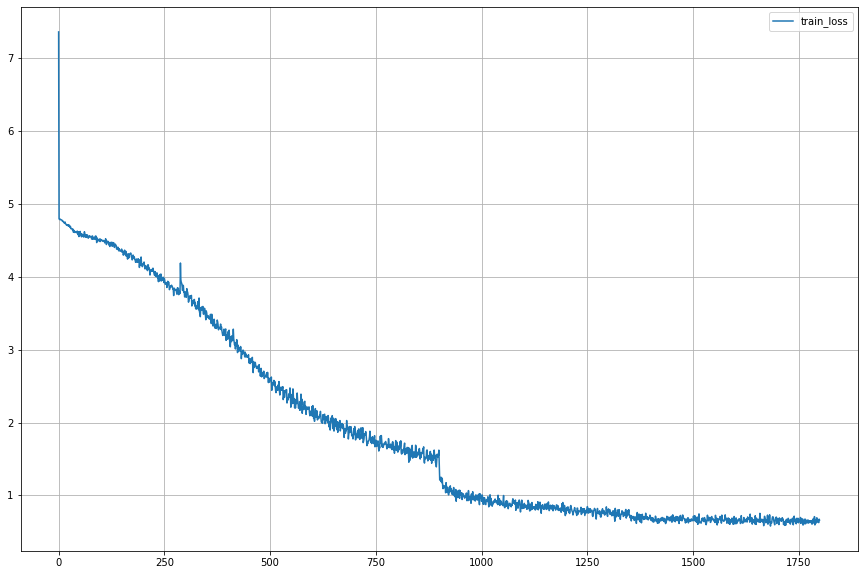

In [16]:
plt.figure(figsize = (15,10))
plt.plot(trn_loss_list, label="train_loss")
plt.legend()
plt.grid('on')
plt.show()